# Exploratory data analysis for Celsia's stoks dataset

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

The first step is a pre-processing and cleaning of the dataset.

In [2]:
file = open('config.json', encoding='utf-8')
config_file = json.load(file)
file.close()

In [3]:
def cleanning_data(data):
    clean = data.copy()
    sort_to = ''

    for i in config_file:
        if (config_file[i] == 'dateTime'):
            clean[i] = pd.to_datetime(clean[i], dayfirst=True)
            sort_to = i
        elif (config_file[i] == 'str'):
            clean[i] = clean[i].str.strip()
        elif (config_file[i] == 'float'):
            clean[i] = clean[i].apply(lambda x: number_cleanning(x, True))
        elif (config_file[i] == 'int'):
            clean[i] = clean[i].apply(lambda x: number_cleanning(x))

    return clean.sort_values(by=sort_to, ascending=True)

def number_cleanning(num, isFloat=False):
    thou_sep = ','
    ans = str(num).lower()
    ans = ans.replace(thou_sep, '')

    tens = dict(k='E+03', m='E+06', b='E+09')
    for word, exp in tens.items():
        ans = ans.replace(word, exp)

    regex_num = '^\D*|\D*$'
    ans = re.sub(regex_num, '', ans)

    if (isFloat):
        return float(ans)
    else:
        return int(float(ans)//1)

In [4]:
path = '../data/raw/CELSIA.csv'
df = pd.read_csv(path, sep=',', header=0, decimal='.')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873 entries, 0 to 3872
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     3873 non-null   object
 1   Último    3873 non-null   object
 2   Apertura  3873 non-null   object
 3   Máximo    3873 non-null   object
 4   Mínimo    3873 non-null   object
 5   Vol.      3873 non-null   object
 6   % var.    3873 non-null   object
dtypes: object(7)
memory usage: 211.9+ KB


In [5]:
df2 = cleanning_data(df)
df2

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
3872,2006-04-25,2610.0,2636.0,2636.0,2604.0,5030000,0.68
3871,2006-04-26,2612.0,2570.0,2616.0,2552.0,4130000,0.08
3870,2006-04-27,2710.0,2716.0,2758.0,2692.0,16630000,3.75
3869,2006-04-28,2716.0,2724.0,2736.0,2716.0,7760000,0.22
3868,2006-05-02,2702.0,2700.0,2720.0,2676.0,5480000,0.52
...,...,...,...,...,...,...,...
4,2022-05-16,4209.0,4155.0,4209.0,4155.0,15900,1.30
3,2022-05-17,4190.0,4200.0,4200.0,4157.0,110700,0.45
2,2022-05-18,4170.0,4195.0,4195.0,4157.0,270920,0.48
1,2022-05-19,4160.0,4160.0,4165.0,4160.0,153510,0.24


Now the raw file is imported.

In [6]:
df_celsia = pd.DataFrame()
df_celsia['Date'] = pd.to_datetime(df2['Fecha'])
df_celsia['Instrument Name'] = 'CELSIA'
df_celsia['Year'] = df_celsia['Date'].dt.year
df_celsia['Month'] = df_celsia['Date'].dt.month
df_celsia['Day'] = df_celsia['Date'].dt.day
df_celsia['Open'] = df2['Apertura']
df_celsia['High'] = df2['Máximo']
df_celsia['Low'] = df2['Mínimo'].astype('float64')
df_celsia['Close'] = df2['Último']
df_celsia['Close previous'] = df2['Último'].shift(1)
df_celsia['Volume'] = df2['Vol.']
df_celsia['Variation'] = df2['Último'].pct_change()*100.0

In [7]:
df_celsia = df_celsia.set_index('Date')
df_celsia.dropna(inplace=True)
df_celsia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3872 entries, 2006-04-26 to 2022-05-20
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Instrument Name  3872 non-null   object 
 1   Year             3872 non-null   int64  
 2   Month            3872 non-null   int64  
 3   Day              3872 non-null   int64  
 4   Open             3872 non-null   float64
 5   High             3872 non-null   float64
 6   Low              3872 non-null   float64
 7   Close            3872 non-null   float64
 8   Close previous   3872 non-null   float64
 9   Volume           3872 non-null   int64  
 10  Variation        3872 non-null   float64
dtypes: float64(6), int64(4), object(1)
memory usage: 363.0+ KB


In the case of Celsia's share, the data set that will be taken as a base contains 3873 rows and 6 columns, with information on Celsia's share since April 2006. Each column has the respective data type (datetime, float , int...) and there are no null values.

In an analysis of the working days for each year, there are many missing days in the years 2009 and 2010, however, unlike what was done with ISA's share, it is not possible to correct these missing days because in the [stock exchange of Colombia](https://www.bvc.com.co/pps/tibco/portalbvc/Home/Mercados/enlinea/acciones) there is only information from 2012. For now this data will be left, however if we notice that they represent too many problems in the model training process, it will be necessary to remove them.

In the general cleaning process, the data format was unified, the values were changed in [scientific notation with prefixes](https://es.wikipedia.org/wiki/Prefijos_del_Sistema_Internacional) to numerical data and the dataset was ordered based on to dates.

The data set obtained after the process is:

In [8]:
df_celsia

,Instrument Name,Year,Month,Day,Open,High,Low,Close,Close previous,Volume,Variation
Date,,,,,,,,,,,
2006-04-26,CELSIA,2006,4,26,2570.0,2616.0,2552.0,2612.0,2610.0,4130000,0.076628
2006-04-27,CELSIA,2006,4,27,2716.0,2758.0,2692.0,2710.0,2612.0,16630000,3.751914
2006-04-28,CELSIA,2006,4,28,2724.0,2736.0,2716.0,2716.0,2710.0,7760000,0.221402
2006-05-02,CELSIA,2006,5,2,2700.0,2720.0,2676.0,2702.0,2716.0,5480000,-0.515464
2006-05-03,CELSIA,2006,5,3,2706.0,2768.0,2700.0,2700.0,2702.0,4760000,-0.074019
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,CELSIA,2022,5,16,4155.0,4209.0,4155.0,4209.0,4155.0,15900,1.299639
2022-05-17,CELSIA,2022,5,17,4200.0,4200.0,4157.0,4190.0,4209.0,110700,-0.451414
2022-05-18,CELSIA,2022,5,18,4195.0,4195.0,4157.0,4170.0,4190.0,270920,-0.477327


In [9]:
df_celsia.describe()

,Year,Month,Day,Open,High,Low,Close,Close previous,Volume,Variation
count,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03,3872.000000
mean,2013.872934,6.494060,15.850981,4227.927092,4263.245868,4195.290367,4231.283316,4230.875258,7.235592e+05,0.028391
std,4.653243,3.434814,8.755129,1227.355644,1234.651829,1219.771414,1227.303465,1227.579825,3.009304e+06,1.797872
min,2006.000000,1.000000,1.000000,1160.000000,1200.000000,1042.000000,1056.000000,1056.000000,7.200000e+02,-16.958277
25%,2010.000000,4.000000,8.000000,3800.000000,3850.000000,3777.500000,3800.000000,3800.000000,8.788750e+04,-0.725953
50%,2014.000000,7.000000,16.000000,4386.500000,4415.000000,4360.000000,4390.000000,4390.000000,2.057050e+05,0.000000
75%,2018.000000,9.000000,23.000000,4980.000000,5000.000000,4910.000000,4980.000000,4980.000000,5.479775e+05,0.769231
max,2022.000000,12.000000,31.000000,6940.000000,7000.000000,6880.000000,7000.000000,7000.000000,1.129200e+08,21.592920


For an initial analysis you can observe some basic statistical data that give a general context of the information with which you are going to work

## Plotting Stock Price Trend and Returns

Based on the economic context of the data, the variables that are of greatest interest to analyze the performance of ISA's share value are the closing price because it shows the final daily valuation and the returns that allow us to visualize the rate of change of action from day to day.


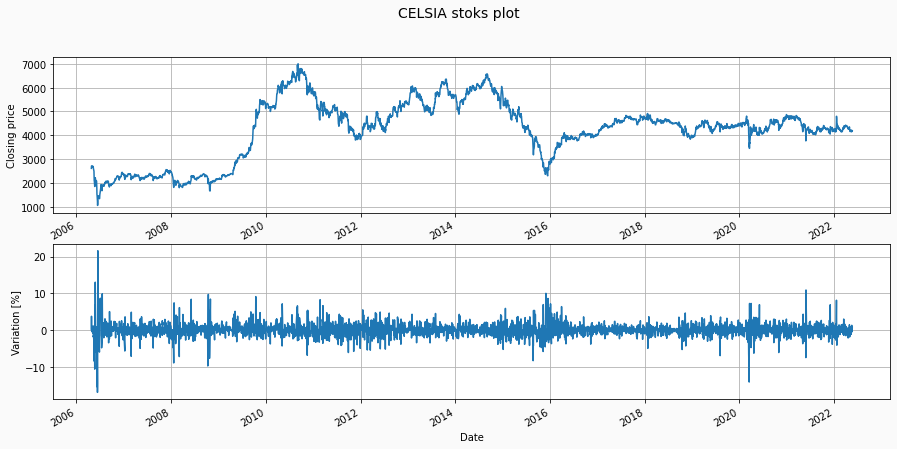

In [10]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig1.suptitle('CELSIA stoks plot', fontsize=14)
ax1 = df_celsia.plot(use_index=True, y='Close', style=['-'], ylabel='Closing price', legend=False, grid=True, ax=axes1[0]);
ax2 = df_celsia.plot(use_index=True, y='Variation', style=['-'], ylabel='Variation [%]', legend=False, grid=True, ax=axes1[1]);

The stock has a mainly stable behavior, with a significant increase in its price at the end of 2009 and a subsequent fall in its value at the end of 2016. It may also see the impact of the covid 19 crisis in 2020 and a significant rebound in 2021.

As for the variation, the first peak is the one that attracts the most attention, however, it is in the year for which there is a lot of data missing, so it is not correct to draw any conclusions in this regard. On the other hand, it can be seen that, as expected, the impact on the stock market caused by the covid 19 health emergency generated a significant variation, although the final price was not very affected.

## Dotted Plot

Again, the dot plot allows us to see in a little more detail the gap between one sample and another, also allowing us to get an idea of how missing data can affect the around 16 years of information we have.

<Figure size 432x288 with 0 Axes>

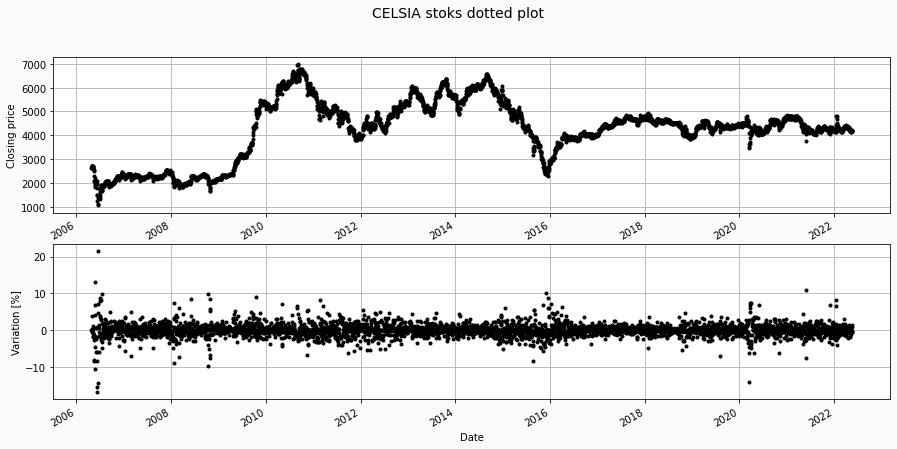

In [11]:
plt.figure()
fig2, axes2 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig2.suptitle('CELSIA stoks dotted plot', fontsize=14)
ax3 = df_celsia['Close'].plot(style='k.', grid=True, ylabel='Closing price', ax=axes2[0]);
ax4 = df_celsia['Variation'].plot(style='k.', grid=True, ylabel='Variation [%]', ax=axes2[1]);

## Histogram of Prices and Returns

Subsequently, we proceed to generate the histogram of our data to make a distribution analysis.

The share price, particularly due to its behavior, presents a multimodal distribution. However, from these data it can be deduced that the current control point (higher frequency) is approximately 4,400 pesos, which has been the approximate value of the share since 2016, ranging between approximately 4,000 and 5,000 pesos.

On the other hand, the variation shows an apparently normal distribution with some very extreme points that reach below -10% and reach almost 10%.

<Figure size 432x288 with 0 Axes>

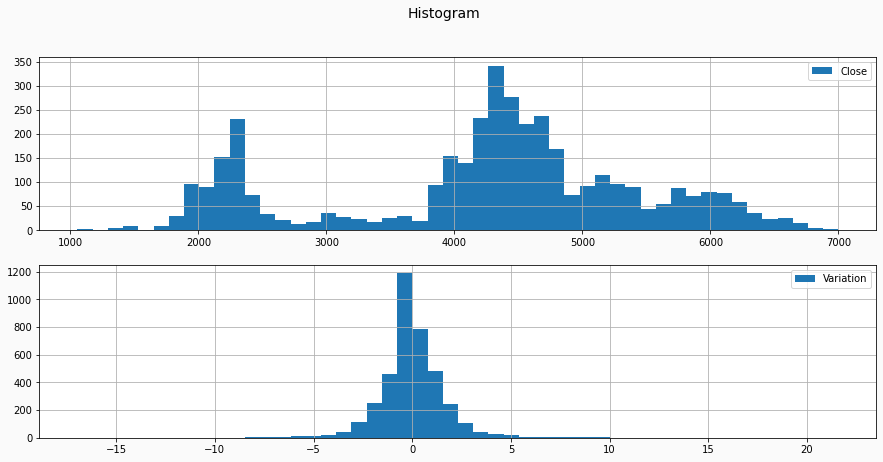

In [12]:
plt.figure()
fig3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig3.suptitle('Histogram', fontsize=14)
ax5 = df_celsia['Close'].hist(bins=50, legend=True, ax=axes3[0]);
ax6 = df_celsia['Variation'].hist(bins=50, legend=True, ax=axes3[1]);

## Kernel Density Plot

Continuing with the previous analysis, a better way to understand the behavior of the price and the variation is by analyzing its density, which by smoothing some data gives us an idea of the distribution of the data and allows us to analyze where the confluence has been greater.

<Figure size 432x288 with 0 Axes>

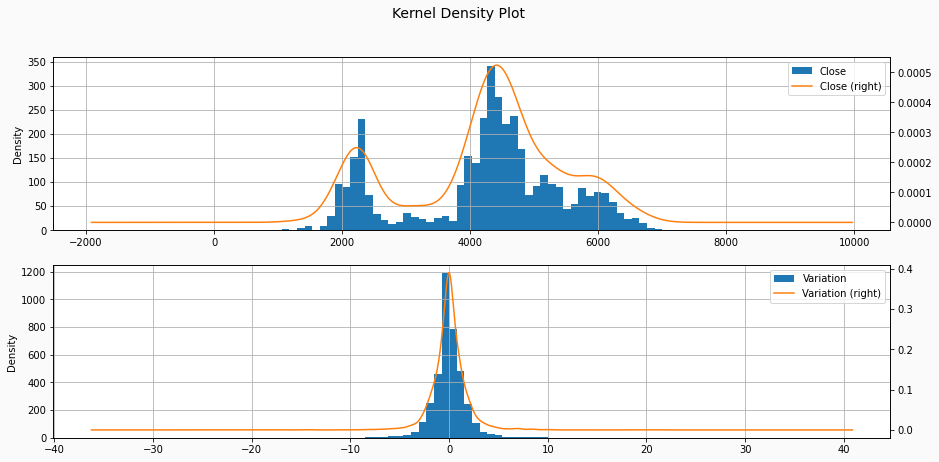

In [13]:
plt.figure()
fig4, axes4 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig4.suptitle('Kernel Density Plot', fontsize=14)
ax5 = df_celsia['Close'].plot(kind='hist', bins=50, legend=True, ax=axes4[0])
ax5 = df_celsia['Variation'].plot(kind='hist', bins=50, legend=True, ax=axes4[1])
ax6 = df_celsia['Close'].plot(kind='kde', grid=True, legend=True, ax=axes4[0], secondary_y=True);
ax6 = df_celsia['Variation'].plot(kind='kde', grid=True, legend=True, ax=axes4[1], secondary_y=True);

## Plotting Moving Average

Another useful strategy for preprocessing time series is to reduce data variance by applying filters. Maintaining the same structure, the first approximation that we present is the moving average, made up of a 200-period window that presents the average evolution of the price based on the previous 200 data. A window of 200 is used because it is an industry standard measure and is used by many institutions to assess stock value.

However, applying low-order filtering models implies, although a low computational cost, a high temporal distortion in the series, since it generates pieces in the sample that, even with a low variation system like this, can generate problems in the prediction system.

<Figure size 432x288 with 0 Axes>

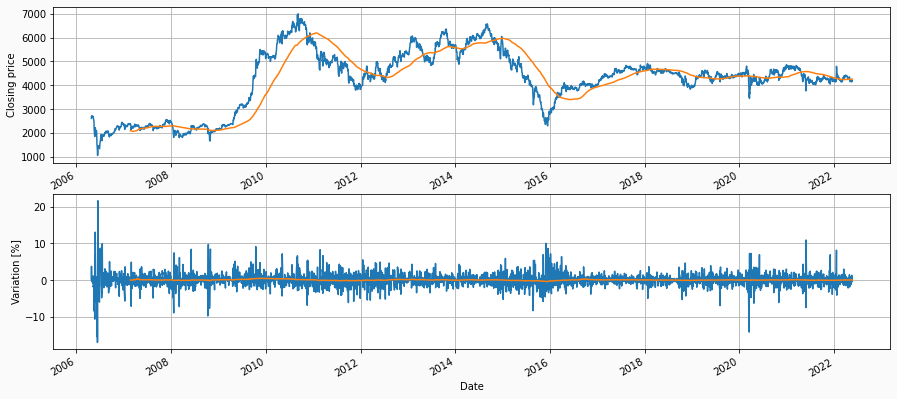

In [14]:
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig4.suptitle('Plotting Moving Average', fontsize=14)

ax1 = df_celsia.plot(use_index=True, y='Close', style=['-'], ylabel='Closing price', legend=False, grid=True, ax=axes[0])
price_mean = df_celsia['Close'].rolling(200, win_type=None).mean()
price_mean.plot(style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=axes[0])

ax2 = df_celsia.plot(use_index=True, y='Variation', style=['-'], ylabel='Variation [%]', legend=False, grid=True, ax=axes[1])
price_mean = df_celsia['Variation'].rolling(200, win_type=None).mean()
price_mean.plot(style=['-', '--', ':'], grid=True, ylabel='Variation [%]', ax=axes[1]);

Just to see the performance for smaller observation windows, it is tested with windows of 50 periods. However, the impact of the temporal displacement generated by this type of implementation continues to be evident.

<Figure size 432x288 with 0 Axes>

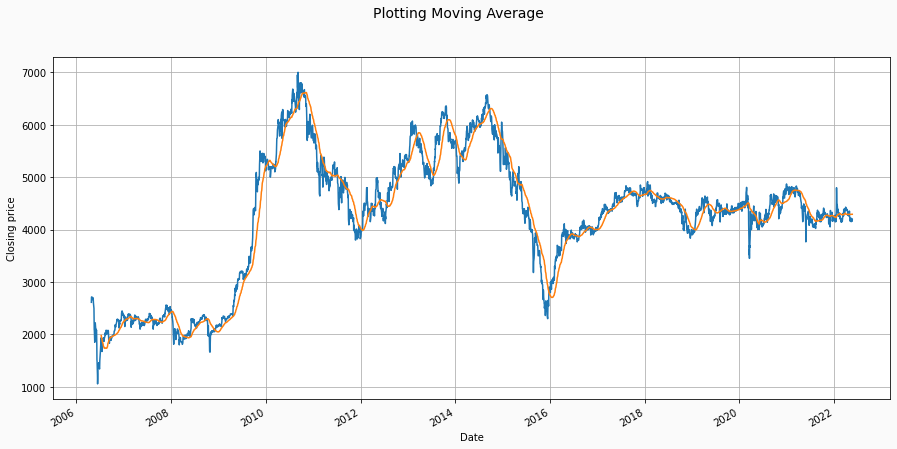

In [15]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Plotting Moving Average', fontsize=14)

ax1 = df_celsia.plot(use_index=True, y='Close', style=['-'], ylabel='Closing price', legend=False, grid=True, ax=axes);
price_mean = df_celsia['Close'].rolling(50, win_type=None).mean()
price_mean.plot(style=['-', '--', ':'], grid=True, ax=axes);

## Exponential Smoothing

In search of reducing the noise of the data, the exponential smoothing filter allows to mitigate the noise without very large implications in time shifts compared to the real data.

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 432x288 with 0 Axes>

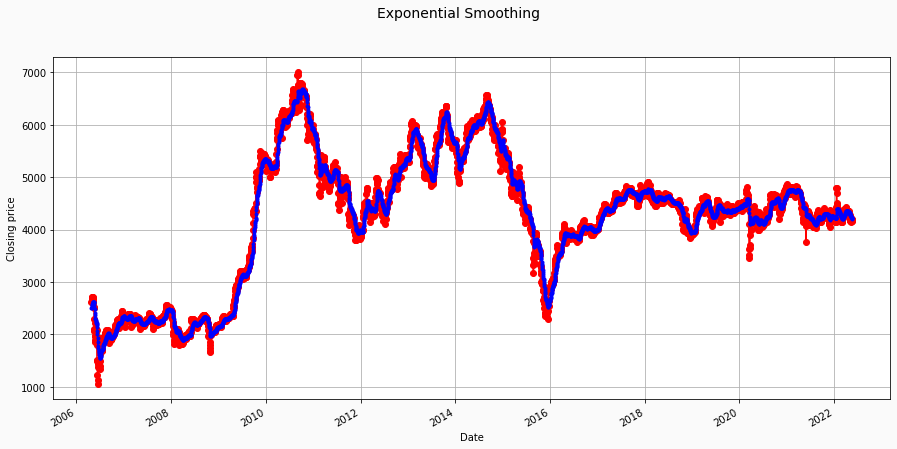

In [16]:
model = SimpleExpSmoothing(df_celsia['Close']).fit(smoothing_level=.1, optimized=True)

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Exponential Smoothing', fontsize=14)
ax = df_celsia['Close'].plot(marker='o', color='red', ylabel='Closing price', ax=axes);
model.fittedvalues.plot(marker='.', color='blue', grid=True, ax=axes);

## Lag plot 

Lag plot allows to do a price analysis between the observation of the sample in *t* and *t+1* where it is tried to verify if there is any pattern that shows that the series is not random, in other words to verify the existence of correlation between the samples. In the case of the closing price of the CELSIA share, there is a positive correlation, which finally implies that its behavior can be modeled.

<Figure size 432x288 with 0 Axes>

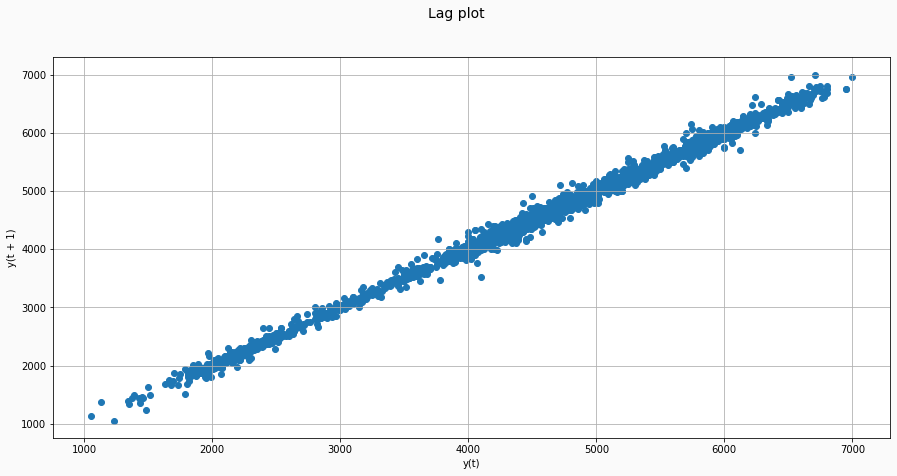

In [17]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Lag plot ', fontsize=14)
ax = lag_plot(df_celsia['Close'], lag=1, ax=axes);
ax.grid()

## Autocorrelation Plot

Finally for the autocorrelation graph, and as expected for a system with such little variation, it seems to be apparently independent of time, despite logic telling us otherwise, it is an important factor to take into account in case At the moment we have problems of autocorrelated variables.

<Figure size 432x288 with 0 Axes>

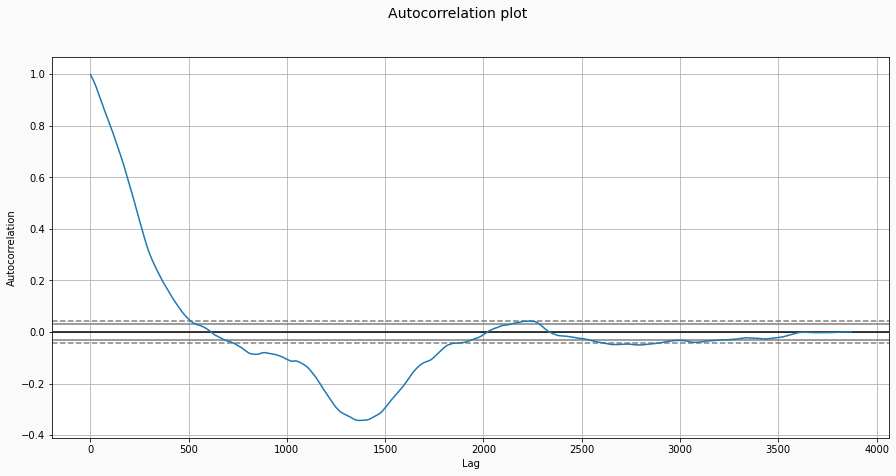

In [18]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Autocorrelation plot', fontsize=14)
autocorrelation_plot(df_celsia['Close'], ax=axes);

## Distribution of the other parameters
Although until now the analysis has been done only of the closing price and the returns, since they are the variables of greatest interest at an economic level; For data science analysis, it is important to have a notion of all the variables, so an analysis of the distribution of the other parameters will be made.

<Figure size 432x288 with 0 Axes>

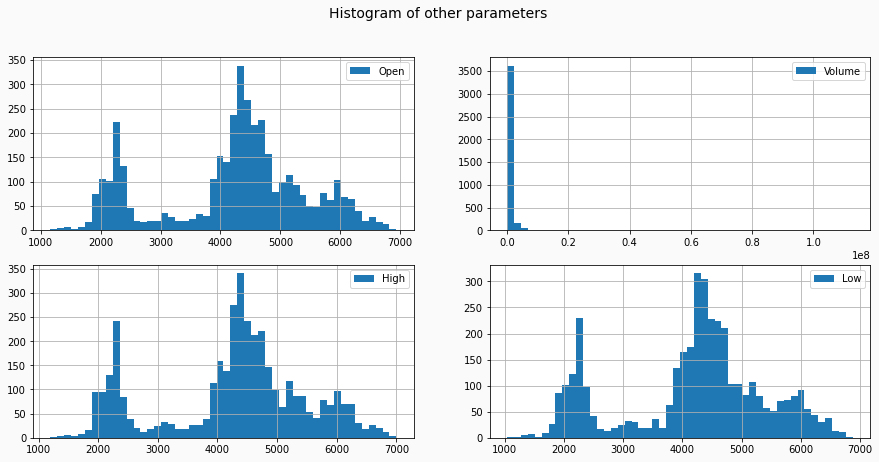

In [19]:
plt.figure()
fig3, axes3 = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), facecolor=(.98, .98, .98))
fig3.suptitle('Histogram of other parameters', fontsize=14)
ax5 = df_celsia['Open'].hist(bins=50, legend=True, ax=axes3[0,0]);
ax6 = df_celsia['Volume'].hist(bins=50, legend=True, ax=axes3[0,1]);
ax6 = df_celsia['High'].hist(bins=50, legend=True, ax=axes3[1,0]);
ax6 = df_celsia['Low'].hist(bins=50, legend=True, ax=axes3[1,1]);

It can be seen that for all the monetary values (`Open`, `High` and `Low`), although their numerical values vary, they have a distribution very similar to that of the closing price, on the other hand the `Volume` is very skewed to the left, this can be analyzed with the interquartile values, which gets much larger as you move between quartiles.

In [20]:
df_celsia['Volume'].quantile([0, 0.05, 0.25, 0.5, 0.9, 1])

0.00          720.0
0.05        24152.0
0.25        87887.5
0.50       205705.0
0.90      1530000.0
1.00    112920000.0
Name: Volume, dtype: float64

## Variation analysis of clossing price and volume per year
The idea is to check if it is possible to find repetitive patterns in annual periods.

<Figure size 432x288 with 0 Axes>

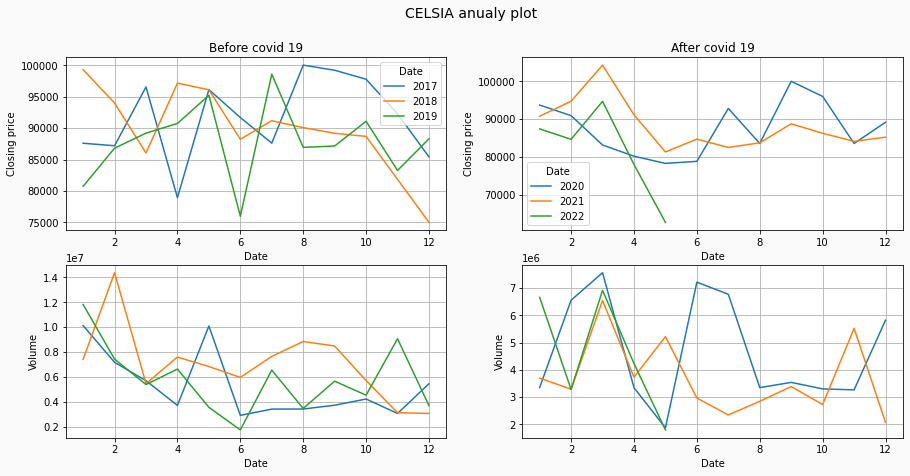

In [21]:
plt.figure()
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), facecolor=(.98, .98, .98))
fig1.suptitle('CELSIA anualy plot', fontsize=14)

df_aux = df_celsia.loc['2017-01-01':'2019-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1[0,0])
ax1.set_title('Before covid 19')

df_aux = df_celsia.loc['2020-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1[0,1])
ax1.set_title('After covid 19')

df_aux = df_celsia.loc['2017-01-01':'2019-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Volume', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Volume', legend=False, grid=True, ax=axes1[1,0])

df_aux = df_celsia.loc['2020-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Volume', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Volume', grid=True, legend=False, ax=axes1[1,1])

Despite the fact that there is no predominant or very noticeable pattern, there is an affectation in the number of shares sold, prior to the start of the pandemic, but an unexpected stability in the closing value of the share in the pandemic period.

## Seasonal subseries plot
Finally, an interesting analysis to perform on the time series is a seasonal price analysis of both the stock's closing price and its sales volume.

In [22]:
years = df_celsia['Year'].unique()
vol_yearly = pd.DataFrame()
close_yearly = pd.DataFrame()
for y in years:
    df_aux = df_celsia[df_celsia['Year']==y].groupby('Month')[['Volume','Close']].mean()
    vol_yearly = pd.concat([vol_yearly, df_aux[['Volume']].T.set_index(pd.Index([y]))])
    close_yearly = pd.concat([close_yearly, df_aux[['Close']].T.set_index(pd.Index([y]))])

In [23]:
vol_yearly_mean = pd.DataFrame()
close_yearly_mean = pd.DataFrame()
for y in years:
    vol_yearly_mean[y] = vol_yearly.mean()
    close_yearly_mean[y] = close_yearly.mean()

<Figure size 432x288 with 0 Axes>

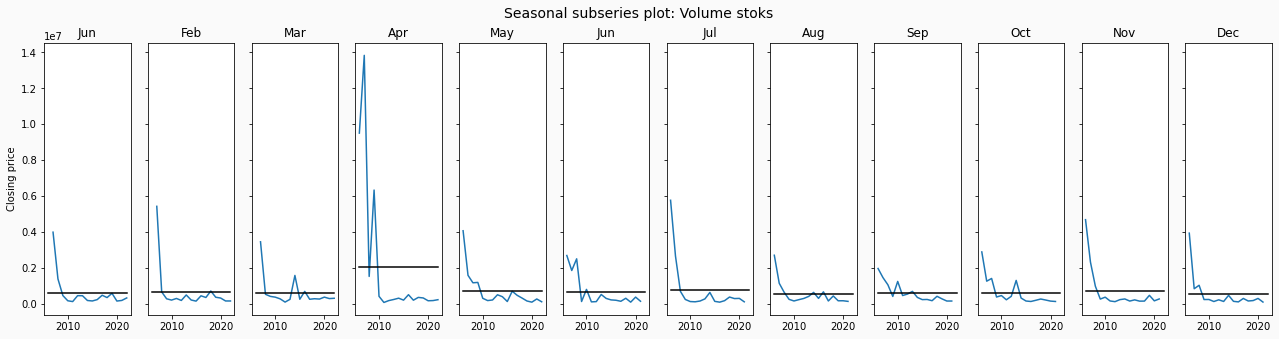

In [24]:
months = ['Jun', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=12, figsize=(22, 5), sharey=True, facecolor=(.98, .98, .98))
fig1.suptitle('Seasonal subseries plot: Volume stoks', fontsize=14)
for i in vol_yearly:
    vol_yearly[i].plot(grid=True, legend=False, title=months[i-1], ylabel='Closing price', ax = axes1[i-1]);
    vol_yearly_mean.T[i].plot(legend=False, ax = axes1[i-1], color ='k');

<Figure size 432x288 with 0 Axes>

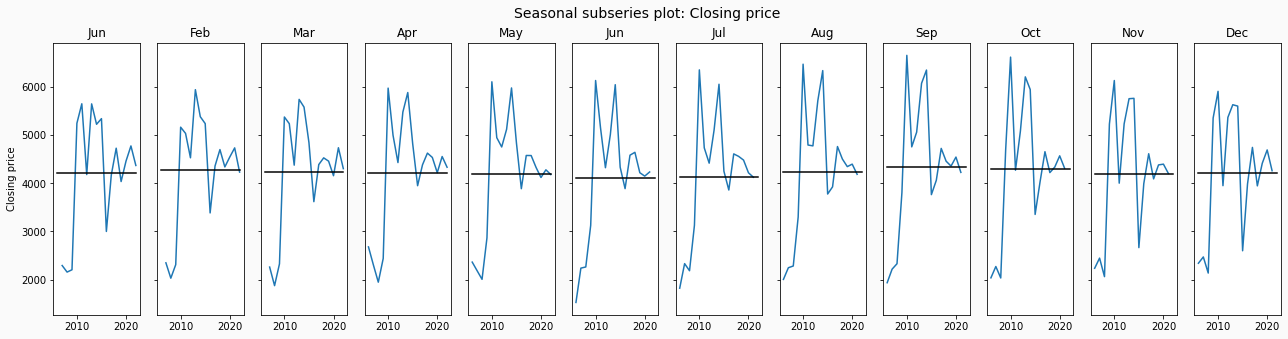

In [25]:
plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=12, figsize=(22, 5), sharey=True, facecolor=(.98, .98, .98))
fig1.suptitle('Seasonal subseries plot: Closing price', fontsize=14)
for i in close_yearly:
    close_yearly[i].plot(grid=True, legend=False, title=months[i-1], ylabel='Closing price', ax = axes1[i-1]);
    close_yearly_mean.T[i].plot(legend=False, ax = axes1[i-1], color ='k');

In [26]:
path_out = '../data/dev/CELSIA.csv'
df_celsia.to_csv(path_out, encoding='utf-8')